# Goal Recognition as a Deep Learning Task: the GRNet Approach

## **1. Setup**

### 1.0 Imports

Python imports.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import os

from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.initializers import Constant
from keras.losses import BinaryCrossentropy
from os.path import join
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
from tqdm import tqdm
from typing import Dict, List, Union

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### 1.1 Custom Classes

Various classes used throughout the notebook.

#### Network classes

Code from 
*Yang, Z.; Yang, D.; Dyer, C.; He, X.; Smola, A. J.; and Hovy, E. H.* 2016. **Hierarchical Attention Networks for Document Classification**
https://github.com/philipperemy/keras-attention-mechanism

In [2]:
class AttentionWeights(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        # self.init = initializers.get(Constant(value=1))

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionWeights, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        return a

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

    def get_config(self):
        config={'step_dim':self.step_dim}
        base_config = super(AttentionWeights, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    




class ContextVector(Layer):
    def __init__(self, **kwargs):
        super(ContextVector, self).__init__(**kwargs)
        self.features_dim = 0

    def build(self, input_shape):
        assert len(input_shape) == 2
        self.features_dim = input_shape[0][-1]
        self.built = True

    def call(self, x, **kwargs):
        assert len(x) == 2
        h = x[0]
        a = x[1]
        a = K.expand_dims(a)
        weighted_input = h * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0][0], self.features_dim

    def get_config(self):
        base_config = super(ContextVector, self).get_config()
        return dict(list(base_config.items()))

#### Constants class

In [3]:
class C:
    '''
    Constants class.
    '''
    OBSERVATIONS = 0
    CORRECT_GOAL = 1
    POSSIBLE_GOALS = 2 
    
    SATELLITE = 0
    LOGISTICS = 1
    ZENOTRAVEL = 2
    BLOCKSWORLD = 3
    DRIVERLOG = 4
    DEPOTS = 5
    
    MAX_PLAN_LENGTH = 0
    MODEL_FILE = 1
    DICTIONARIES_DICT = 2
    
    SMALL = 0
    COMPLETE = 1
    PERCENTAGE = 2
    
    MODELS_DIR = '../models/'
    DICTIONARIES_DIR = './dictionaries/'
    #MODELS_DIR = './incremental_models/'
    
    MODEL_LOGISTICS = None
    MODEL_SATELLITE = None
    MODEL_ZENOTRAVEL = None
    MODEL_BLOCKSWORLS = None
    MODEL_DRIVERLOG = None
    MODEL_DEPOTS = None

    MAX_PLAN_PERCENTAGE = 0.7

    TABLE_HEADERS = ['', 'Pereira', 'Our', 'Support']
    
    CUSTOM_OBJECTS = {'AttentionWeights': AttentionWeights,
                   'ContextVector' : ContextVector,
                   'custom_multilabel_loss_v3' : BinaryCrossentropy}


#### Exceptions

In [4]:
class PlanLengthError(Exception):
    pass

class FileFormatError(Exception):
    pass

class UnknownIndexError(Exception):
    pass

### 1.2 Custom Methods

Various methods used throughout the notebook.

#### Unpack files methods

In [5]:
def unzip_file(file_path: str, target_dir: str) -> None:
    '''
    Unzip a file in an empty directory. The directory is 
    emptied before the execution.
    
    Args:
        file_path:
            A string that contains the path
            to the .zip file.
        
        target_dir:
            A string that contains the path 
            to the target directory. This 
            directory is created if it doesn't
            exist and it is emptied if it exists.
        
    '''
    if os.path.exists(target_dir):
        for f in os.listdir(target_dir):
            os.remove(join(target_dir, f))
        os.rmdir(target_dir)
    os.mkdir(target_dir)
    os.system(f'unzip -qq {file_path} -d {target_dir}')
    
def unpack_bz2(file_path: str, target_dir: str) -> None:
    '''
    Unpack a .bz2 file in an empty directory. The directory 
    is emptied before the execution.
    
    Args:
        file_path:
            A string that contains the path
            to the .bz2 file.
        
        target_dir:
            A string that contains the path 
            to the target directory. This 
            directory is created if it doesn't
            exist and it is emptied if it exists.
        
    '''
    if os.path.exists(target_dir):
        for f in os.listdir(target_dir):
            os.remove(join(target_dir, f))
        os.rmdir(target_dir)
    os.mkdir(target_dir)
    os.system(f'tar -xf {file_path} -C {target_dir}')

#### Input parse methods

In [6]:
def load_file(file: str, binary: bool = False, use_pickle: bool = False):
    '''
    Get file content from path.
    
    Args:
        file:
            A string that contains the path
            to the file.
        binary:
            Optional. True if the file is a 
            binary file.
        use_pickle:
            Optional. True if the file was 
            saved using pickle.
            
    Returns:
        The content of the file.
    
    Raises:
        FileNotFoundError:
            An error accessing the file
    '''
    operation = 'r'
    if binary:
        operation += 'b'
    with open(file, operation) as rf:
        if use_pickle:
            output = pickle.load(rf)
        else:
            output = rf.readlines()
        rf.close()
    return output
        
        

In [7]:
def parse_file(read_file: str, content_type: int, dictionary: dict = None):
    '''
    Parse different input files.
    
    Args:
        read_file: 
            String containing the path to the file.
        content_type: 
            Integer representing the kind of parse to apply.
                0: observations file,
                1: correct goal file, 
                2: possible goals file
        
    Returns:
        A list of strings that contains the parsed elements.
        
    Raises:
        FileFormatError: 
            An error regarding the action format in 
            the file   
    '''
    
    msg_empty = f'File {read_file} is empty.'
    msg_index = f'Content type {content_type} is unknown.' 
    
    elements = list()
    
    lines = load_file(read_file)
    if len(lines) == 0:
        raise FileFormatError(msg_empty)
    if content_type == C.OBSERVATIONS:
        elements = parse_observations(lines, dictionary)
    elif content_type == C.POSSIBLE_GOALS:
        elements = parse_possible_goals(lines, dictionary)
    elif content_type == C.CORRECT_GOAL:
        elements = parse_correct_goal(lines[0], dictionary)
    else:
        raise UnknownIndexError(msg_index)
    
    if len(elements) > 0:    
        return elements
    else:
        raise FileFormatError(msg_empty)
        

def remove_parentheses(line: str) -> str:
    '''
    Remove parentheses from a string.
    
    Args:
        line: a string that is enclosed in parentheses.
        For example:
        
        "(string example)"
        
    Returns:
        The string without the parenteses.
        None if the string is empty.
        
    Raises:
        FileFormatError: error handling the string
    '''
    
    msg = (f'Error while parsing a line. Expected "(custom '
    +f'text)" but found "{line}"')
    
    line = line.strip()
    if line.startswith('(') and line.endswith(')'):
        element = line[1:-1]
        element = element.strip()
        if len(element) == 0:
            return None
        else:
            return element
    elif len(line) == 0:
        return None
    else:
        raise FileFormatError(msg)
        
def retrieve_from_dict(key: str, dictionary: dict):
    '''
    Return the dictionary value given the key.
    
    Args:
        key:
            A string that is the key.
        dictionary:
            A dict.
            
    Returns:
        The value corresponding to the key.
    
    Raises:
        KeyError:
            An error accessing the dictionary.
    '''
    
    msg_error = f'Key {key.upper()} is not in the dictionary'
    
    try:
        return dictionary[key.upper()]
    except KeyError:
        print(msg_error)
        np.random.seed(47)
        return np.random.randint(0,len(dictionary))

def parse_correct_goal(line: str, goals_dict: dict = None) -> list:
    '''
    Parse the fluents that compose a goal.
    
    Args:
        line: 
            A string that contains one or more 
            fluents in the goal. Fluents are 
            enclosed in parentheses and separated
            by commas. For example:
            
            "(fluent1), (fluent2),  (fluent3)"
        
        goals_dict:
            Optional. A dictionary that maps each 
            fluent to its unique identifier.
    
    Returns:
        A list of strings containing each fluent 
        without parentheses.
        
    Raises:
        FileFormatError:
            An error accessing the file.
    '''
    msg_empty = 'Parsed goal is empty.'
    
    goal = list()
    line = line.strip()
    fluents = line.split(',')
    for f in fluents:
        fluent = remove_parentheses(f)
        if fluent is not None:
            if goals_dict is not None:
                fluent = retrieve_from_dict(fluent, goals_dict)
            goal.append(fluent)
    if len(goal) > 0:
        return goal
    else:
        raise FileFormatError(msg_empty)
    

        
def parse_observations(lines: list, obs_dict: dict = None) -> list:
    '''
    Removes parentheses and empty strings from 
    the observations list.
    
    Args:
        lines: 
            List of strings that contains the 
            observations. Each observation is
            enclosed in parentheses. For 
            example:
            
            ['(observation1)', '', '(observation2)']
        
        obs_dict:
            Optional. A dictionary that maps each 
            observation to its unique identifier.
            
    Returns:
        The input list without parentheses and
        empty strings.
        
    Raises:
        FileFormatError:
            An error accessing the file.
    '''
    msg_empty='Observations list is empty.'
    
    observations = list()
    
    for line in lines:
        observation = remove_parentheses(line)
        if observation is not None:
            if obs_dict is not None:
                observation = retrieve_from_dict(observation, obs_dict)
            observations.append(observation)
    if len(observations)>0:
        return observations
    else:
        raise FileFormatError(msg_empty)

def parse_possible_goals(lines: list, goals_dict: dict = None) -> list:
    '''
    Parse a list of goals.
    
    Args:
        lines:
            A list of strings that contains each
            possible goal.
            
        goals_dict:
            Optional. A dictionary that maps each 
            fluent to its unique identifier.
    
    Returns:
        A list of lists. Each list contains the fluents
        that compose the goal represented as a string.
        
    Raises:
        FileFormatError:
            An error accessing the file.
    '''
    msg_empty='Possible goals list is empty.'
    
    goals=list()
    for line in lines:
        line = line.strip()
        if len(line)>0:
            goals.append(parse_correct_goal(line, goals_dict))
    if len(goals) > 0:
        return goals
    else:
        raise FileFormatError(msg_empty)
            
            

#### Model related methods

In [8]:
def parse_domain(domain: Union[str, int]) -> int:
    '''
    Converts domain name into integer
    
    Args:
        domain: 
            A string or an int that represents
            a domain.
    
    Returns:
        An integer associated to a specific domain.
        
    Raises:
        KeyError:
            An error parsing the domain arg.
    '''
    msg = (f'Provided domain {domain} is not supported. '+
           f'Supported domains are: {C.SATELLITE} : satellite, ' +
           f'{C.LOGISTICS} : logistics, {C.BLOCKSWORLD} : blocksworld, ' +
           f'{C.ZENOTRAVEL} : zenotravel, {C.DRIVERLOG}: driverlog,' + 
           f'{C.DEPOTS}: depots.')
           
    if (str(domain).isdigit() and int(domain) == C.SATELLITE) or str(domain).lower().strip() == 'satellite':
        return C.SATELLITE
    elif (str(domain).isdigit() and int(domain) == C.LOGISTICS) or str(domain).lower().strip() == 'logistics':
        return C.LOGISTICS
    elif (str(domain).isdigit() and int(domain) == C.BLOCKSWORLD) or str(domain).lower().strip() == 'blocksworld':
        return C.BLOCKSWORLD
    elif (str(domain).isdigit() and int(domain) == C.ZENOTRAVEL) or str(domain).lower().strip() == 'zenotravel':
        return C.ZENOTRAVEL
    elif (str(domain).isdigit() and int(domain) == C.DRIVERLOG) or str(domain).lower().strip() == 'driverlog':
        return C.DRIVERLOG
    elif (str(domain).isdigit() and int(domain) == C.DEPOTS) or str(domain).lower().strip() == 'depots':
        return C.DEPOTS
    else:
        raise KeyError(msg)

In [9]:
def get_model(domain: int):
    '''
    Loads the model for a specific domain.
    
    Args:
        domain: 
            an integer associated to a specific 
            domain.
            
    Returns:
        The Model loaded for the domain or None
        if there is no model in memory.
        
    Raises:
        KeyError:
            An error parsing the domain arg.
    '''

    msg = (f'Provided domain {domain} is not supported. '+
       f'Supported domains are: {C.SATELLITE} : satellite, ' +
       f'{C.LOGISTICS} : logistics, {C.BLOCKSWORLD} : blocksworld, ' +
       f'{C.ZENOTRAVEL} : zenotravel, {C.DRIVERLOG}: driverlog,' + 
       f'{C.DEPOTS}: depots.')
    
    if domain == C.LOGISTICS:
        return C.MODEL_LOGISTICS
    elif domain == C.SATELLITE:
        return C.MODEL_SATELLITE
    elif domain == C.DEPOTS:
        return C.MODEL_DEPOTS
    elif domain == C.BLOCKSWORLD:
        return C.MODEL_BLOCKSWORLS
    elif domain == C.DRIVERLOG:
        return C.MODEL_DRIVERLOG
    elif domain == C.ZENOTRAVEL:
        return C.MODEL_ZENOTRAVEL
    else:
        raise KeyError(msg)

In [10]:
def get_domain_related(domain: int, element: int, model_type: int = C.SMALL, 
                       percentage: float = 0) -> Union[int, str]:
    '''
    Returns domain related information
    
    Args:
        domain: 
            an integer associated to a specific 
            domain.
        
        element:
            an integer associated to a specific
            piece of information to retrieve.
        
        model_type:
            an integer associated to the type
            of RNN model in use.
        
        percentage:
            a float that represents the model
            percentage to use. Use only with
            model_type = C.PERCENTAGE.
    
    Returns: 
        Max plan size if element=C.MAX_PLAN_LENGTH,
        Model file if element=C.MODEL_FILE
        Dictionaries directory if element=C.DICTIONARIES_DICT
        
    '''
    
    msg = (f'Provided domain {domain} is not supported. '+
           f'Supported domains are: {C.SATELLITE} : satellite, ' +
           f'{C.LOGISTICS} : logistics, {C.BLOCKSWORLD} : blocksworld, ' +
           f'{C.ZENOTRAVEL} : zenotravel.')
    if domain == C.LOGISTICS:
        v = {
            'max_plan_len' : 50,
            'name' : 'logistics',
        }
    elif domain == C.SATELLITE:
        v = {
            'max_plan_len' : 40,
            'name' : 'satellite',
        }
    elif domain == C.ZENOTRAVEL:
        v = {
            'max_plan_len' : 40,
            'name' : 'zenotravel',
        }
    elif domain == C.BLOCKSWORLD:
        v = {
            'max_plan_len' : 75,
            'name' : 'blocksworld',
        }
    elif domain == C.DRIVERLOG:
        v = {
            'max_plan_len' : 70,
            'name' : 'driverlog',
        }
    elif domain == C.DEPOTS:
        v = {
            'max_plan_len' : 64,
            'name' : 'depots'
        }
    else:
        raise KeyError(msg)
        
    if element == C.MAX_PLAN_LENGTH:
        return int(v['max_plan_len']*C.MAX_PLAN_PERCENTAGE)
    
    elif element == C.MODEL_FILE:
        if model_type == C.COMPLETE:
            return f'{v["name"]}.h5'
        elif model_type == C.SMALL:
            return f'{v["name"]}_small.h5'
        elif model_type == C.PERCENTAGE:
            return f'{v["name"]}_{int(percentage*100)}perc.h5'
        
    elif element == C.DICTIONARIES_DICT:
        return join(C.DICTIONARIES_DIR, f'{v["name"]}')


#### Domain component methods

In [11]:
def get_observations_array(observations: list, max_plan_length: int) -> np.ndarray:
    '''
    Create an array of observations index.
    
    Args:
        observations: 
            A list of action names
            
        max_plan_length:
            An integer that contains the maximum size of
            the list that will be considered.
    
    Returns:
        An array that contains the observations' indexes
    '''
    
    WARNING_MSG = (f'The action trace is too long. Only the first {max_plan_length}'+
                 f'actions will be considered.')
    
    observations_array = np.zeros((1, max_plan_length))
    if len(observations) > max_plan_length:
        pass
        # print(WARNING_MSG)
    for index, observation in enumerate(observations):
        if index < max_plan_length:
            observations_array[0][index] = int(observation)
    return observations_array
        

def get_predictions(observations: list, 
                    max_plan_length: int, 
                    domain: int) -> np.ndarray:
    '''
    Return the model predictions.
    
    Args:
        observations:
            A list of action names.
        
        max_plan_length:
            An integer that contains the maximum size of
            the list that will be considered.
        
        domain:
            An integer associated to a specific domain.
    
    Returns:
        The model predictions.
    '''

    model = get_model(domain)
    
    model_input = tf.convert_to_tensor(get_observations_array(observations, max_plan_length))
    y_pred = model.predict(model_input)
    return y_pred



#### GR Instance component methods

In [12]:
def get_score(prediction: np.ndarray, possible_goal: list) -> float:
    '''
    Returns the score for a possible goal.
    
    Args:
        prediction:
            An array that contains the model prediction.
        
        possible_goal:
            A list that contains the possible goal indexes.
        
    Returns:
        An float that represents the score of the possible goal.
    '''
    
    score=0
    
    for index in possible_goal:
        score += prediction[0][int(index)]
    return score

def get_scores(prediction: np.ndarray, possible_goals: list) -> np.ndarray:
    '''
    Returns the scores for all possible goals.
    
    Args:
        prediction:
            An array that contains the model prediction.
        
        possible_goals:
            A list of possible goals; each possible goal is represented as a
            list
        
    Returns:
        An array that contains the score of each of the possible goals.
    '''
    scores = np.zeros((len(possible_goals, )), dtype=float)
    for index, possible_goal in enumerate(possible_goals):
        scores[index] = get_score(prediction, possible_goal)
    return scores
        

def get_max(scores: np.ndarray) -> list:
    '''
    Returns a list with the index (or indexes) of the highest scores.
    
    Args:
        scores:
            An array that contains the scores as floats.
    
    Returns:
        A list thet contains the indexes of the highest score.
    '''
    max_element = -1
    index_max = list()
    for i in range(len(scores)):
        if scores[i] > max_element:
            max_element = scores[i]
            index_max = [i]
        elif scores[i] == max_element:
            index_max.append(i)

    return index_max
    
def get_result(scores: np.ndarray, correct_goal: int) -> bool:
    '''
    Computes if the goal recognition task is successfull.
    
    Args:
        scores:
            An array of floats that contains a score for 
            each possible goal
        correct_goal: 
            An integer that represents the index of the 
            correct goal
            
    Returns:
        True if the maximum score index corresponds to the 
        correct goal index, False otherwise.
    '''
    idx_max_list = get_max(scores)
    if len(idx_max_list) == 1:
        idx_max = idx_max_list[0]
    else:
        # print(f'Algorithm chose randomly one of {len(idx_max_list)} equals candidates.')
        idx_max = idx_max_list[np.random.randint(0, len(idx_max_list))]
    if idx_max == correct_goal:
        return True
    else:
        return False
    
def get_correct_goal_idx(correct_goal: list, possible_goals: list) -> int:
    '''
    Conputes the correct goal index.
    
    Args:
        correct_goal:
            A list of strings that contains the correct goal
            fluents.
        possible_goals:
            A list of possible goals; each possible goal is represented as a
            list.
    
    Returns:
        The index of the correct goal in the possible goals list.
        None if the possible goal list does not contain the correct goal.
    '''
    
    for index, possible_goal in enumerate(possible_goals):
        possible_goal = np.sort(possible_goal)
        correct_goal = np.sort(correct_goal)
        if np.all(possible_goal == correct_goal):
            return index
    return None

#### GRNet execution methods

In [13]:
def init_models(model_type: int, percentage: float)-> None:
    '''
    Loads in memory all the models.
    
    Args:
        model_type:
            an integer associated to the type
            of RNN model in use.
        
        percentage:
            a float that represents the model
            percentage to use. Use only with
            model_type = C.PERCENTAGE.
    
    Returns:
        None   
    '''
    
    model_file = get_domain_related(C.LOGISTICS, C.MODEL_FILE, model_type=model_type, percentage=percentage)
    C.MODEL_LOGISTICS =  load_model(join(C.MODELS_DIR, model_file), custom_objects=C.CUSTOM_OBJECTS)
    
    model_file = get_domain_related(C.SATELLITE, C.MODEL_FILE, model_type=model_type, percentage=percentage)
    C.MODEL_SATELLITE = load_model(join(C.MODELS_DIR, model_file), custom_objects=C.CUSTOM_OBJECTS)
    
    model_file = get_domain_related(C.ZENOTRAVEL, C.MODEL_FILE, model_type=model_type, percentage=percentage)
    C.MODEL_ZENOTRAVEL = load_model(join(C.MODELS_DIR, model_file), custom_objects=C.CUSTOM_OBJECTS)
    
    model_file = get_domain_related(C.DEPOTS, C.MODEL_FILE, model_type=model_type, percentage=percentage)
    C.MODEL_DEPOTS = load_model(join(C.MODELS_DIR, model_file), custom_objects=C.CUSTOM_OBJECTS)
    
    model_file = get_domain_related(C.DRIVERLOG, C.MODEL_FILE, model_type=model_type, percentage=percentage)
    C.MODEL_DRIVERLOG =  load_model(join(C.MODELS_DIR, model_file), custom_objects=C.CUSTOM_OBJECTS)
    
    model_file = get_domain_related(C.BLOCKSWORLD, C.MODEL_FILE, model_type=model_type, percentage=percentage)
    C.MODEL_BLOCKSWORLS =  load_model(join(C.MODELS_DIR, model_file), custom_objects=C.CUSTOM_OBJECTS)

In [14]:
def run_experiment(obs_file: str, 
            goals_dict_file: Union[str, None],
            actions_dict_file: Union[str, None],
            possible_goals_file: str, 
            correct_goal_file: str, 
            domain: Union[str, int], 
            verbose: int = 0) -> list:
    '''
    Run the goal recognition experiment

    Args:
        obs_file:
            Path of the file that contains the
            observations (plan)

        goals_dict_file:
            Path of the file that contains the
            goals dictionaries. If None it is
            retrieved from its default location.

        actions_dict_file:
            Path of the file that contains the
            actions dictionaries. If None it is
            retrieved from its default location.

        possible_goals_file:
            Path of the file that contains the
            possible goals.

        correct_goal_file:
            Path of the file that contains the
            correct goal.

        domain:
            String that contains the name of the
            domain or integer that corresponds to
            a domain.

        verbose:
            Integer that corresponds to how much
            information is printed. 0 = no info,
            2 = max info

    Returns:
         A list that contains the result, the correct
         goal index and the predicted goal index.
    '''

    domain = parse_domain(domain)
    if goals_dict_file is None:
        goals_dict_file = join(get_domain_related(domain, C.DICTIONARIES_DICT), 'dizionario_goal')
    goals_dict = load_file(goals_dict_file, binary=True, use_pickle=True)
    if actions_dict_file is None:
        actions_dict_file = join(get_domain_related(domain, C.DICTIONARIES_DICT), 'dizionario')
    actions_dict = load_file(actions_dict_file, binary=True, use_pickle=True)
    observations = parse_file(obs_file, C.OBSERVATIONS, actions_dict)
    
    if verbose > 1:
        print('Observed actions:\n')
        for o in observations:
            print(o)
    possible_goals = parse_file(possible_goals_file, C.POSSIBLE_GOALS, goals_dict)
    
    max_plan_length = get_domain_related(domain, C.MAX_PLAN_LENGTH)
    predictions = get_predictions(observations, max_plan_length, domain)
    scores = get_scores(predictions, possible_goals)
    if verbose > 0:
        for index, goal in enumerate(possible_goals):
            print(f'{index} - {goal} : {scores[index]}')
    
    correct_goal = parse_file(correct_goal_file, C.CORRECT_GOAL, goals_dict) 
    correct_goal_idx = get_correct_goal_idx(correct_goal, possible_goals)
    result = get_result(scores, correct_goal_idx)
    if verbose > 0:
        print(f'Predicted goal is {get_max(scores)[0]}')
        print(f'Correct goal is {correct_goal_idx} - {correct_goal}')
    return [result, correct_goal_idx, get_max(scores)[0]]



### 1.3 Base Configurations
Various configurations, all main parameters can be adjusted here.

In [15]:
# Domain
DOMAIN = C.BLOCKSWORLD
DOMAIN_NAME = 'blocksworld'

# Paths to testsets and reports
TS_DIR = 'TS_Per' # Either 'TS_PerGen' or 'TS_Per'
ORIGINAL_DOMAIN_DIR = f'../testsets/{TS_DIR}/{DOMAIN_NAME}'
NOISY_DOMAIN_DIR = f'../testsets/{TS_DIR}_noisy/{DOMAIN_NAME}/{DOMAIN_NAME}-noisy'
REPORT_DIR = f'../testsets/{TS_DIR}_noisy/{DOMAIN_NAME}/report/{DOMAIN_NAME}-noisy'

# Evaluation results paths
ORIGINAL_RESULTS_DIR = f'../results/{TS_DIR}/{DOMAIN_NAME}'
NOISY_RESULTS_DIR = f'../results/{TS_DIR}_noisy/{DOMAIN_NAME}'

# Temporary directory to unzip files
TEMP_DIR = f'./files_temp_dir'

# Additional configs
VERBOSE = 0

## **2. GRNet execution**

### 2.0 Common Configurations & Functions

Configurations and functions specific to the execution of GRNet.

In [214]:
# Do not change these values
model_type=C.SMALL 
percentage=0

init_models(model_type=model_type, percentage=percentage)

In [ ]:
def process_domain(
    domain: int,
    domain_dir: str,
    temp_dir: str = './files_temp_dir',
    perc_list: List[float] = [0.1, 0.3, 0.5, 0.7, 1],
    verbose: int = 0
) -> Dict[str, pd.DataFrame]:
    '''
    Process a domain for different observation percentages.
    
    Args:
        domain:
            An integer associated to a specific domain.
        
        domain_dir:
            A string that contains the path to the
            directory that contains the testset.
        
        temp_dir:
            A string that contains the path to a temporary
            directory to extract files to.
        
        perc_list:
            Optional. A list of floats that contains the
            observation percentages to process.
        
        verbose:
            Optional. An integer that corresponds to how much
            information is printed. 0 = no info, 1 = max info.
    
    Returns:
        A dictionary where each key is a string representing
        the observation percentage and each value is a DataFrame
        that contains the results for that observation percentage.
    '''
    results = {}
    times = list()
    for perc in perc_list:
        plans_dir = f'{join(domain_dir, str(int(perc*100)))}'
        files = os.listdir(plans_dir)
        total=0
        correct=0
        rows = []

        domain_name = os.path.basename(domain_dir)
        for j, f in enumerate(tqdm(files, desc=f'[{domain_name}][{int(perc*100)}%] Processing plans', unit='plans')): 
            obs_dir = join(plans_dir, f)
            problem_name = f
            if verbose:
                print(f"File: {f}")
            if f.endswith('.zip'):
                unzip_file(join(plans_dir,f), temp_dir)
                obs_dir = temp_dir
                problem_name = f[:-4]
            elif f.endswith('.bz2'):
                unpack_bz2(join(plans_dir,f), temp_dir)
                obs_dir = temp_dir
                problem_name = f[:-4]
            start_time = time.time()
            result = run_experiment(obs_file=join(obs_dir, 'obs.dat'),
                                    goals_dict_file=None,
                                    actions_dict_file=None,
                                    possible_goals_file=join(obs_dir, 'hyps.dat'),
                                    correct_goal_file=join(obs_dir, 'real_hyp.dat'),
                                    domain=domain, 
                                    verbose=verbose)
            exec_time = time.time()-start_time
            if result[0]:
                correct+=1
            total +=1
            times.append(exec_time)
            if verbose:
                print(f'Execution time: {exec_time} seconds')
            rows.append({
                'problem': problem_name,
                'correct_goal_idx': result[1],
                'predicted_goal_idx': result[2]
            })

        results_df = pd.DataFrame(rows)
        results[f"{int(perc*100)}"] = results_df
    return results

In [216]:
def process_noisy_domain(
    domain: int,
    domain_dir: str,
    temp_dir: str = './files_temp_dir',
    perc_list: List[float] = [0.1, 0.3, 0.5, 0.7, 1],
    noise_perc_list: List[float] = [0.05, 0.1, 0.2, 0.3],
    verbose: int = 0
) -> Dict[str, Dict[str, pd.DataFrame]]:
    '''
    Process a noisy domain for different observation percentages and noise levels.
    
    Args:
        domain:
            An integer associated to a specific domain.
        
        domain_dir:
            A string that contains the path to the
            directory that contains the testset. The inner
            directories (the ones named after noise levels)
            must have the noise level as a suffix (for example, 
            '_5' for 5% noise, '_10' for 10% noise, etc.).
        
        temp_dir:
            A string that contains the path to a temporary
            directory to extract files to.
        
        perc_list:
            Optional. A list of floats that contains the
            observation percentages to process.
        
        noise_perc_list:
            Optional. A list of floats that contains the
            noise levels to process.
        
        verbose:
            Optional. An integer that corresponds to how much
            information is printed. 0 = no info, 1 = max info.
    
    Returns:
        A dictionary where each key is a string representing
        the observation percentage and each value is another
        dictionary. In this second dictionary, each key is a
        string representing the noise level and each value is
        a DataFrame that contains the results for that noise
        level.
    '''
    results = {}
    for noise in noise_perc_list:
        noise_dir = f'{domain_dir}_{int(noise*100)}'
        print(f'=== Processing noise level: {int(noise*100)}% ===')
        results[f"{int(noise*100)}"] = process_domain(
            domain,
            noise_dir,
            temp_dir=temp_dir,
            perc_list=perc_list,
            verbose=verbose
        )
    
    return results


### 2.1 Execution | Original dataset

Domain processing and result saving of the original dataset (without noise).

In [217]:
original_results = process_domain(
    domain=DOMAIN,
    domain_dir=ORIGINAL_DOMAIN_DIR,
)

[blocksworld][10%] Processing plans:   0%|          | 0/246 [00:00<?, ?plans/s]/tmp/ipykernel_280900/2038651677.py:112: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(possible_goal == correct_goal):
[blocksworld][100%] Processing plans: 100%|██████████| 92/92 [00:01<00:00, 53.75plans/s]


In [218]:
original_results["100"].head()

,problem,correct_goal_idx,predicted_goal_idx
0,block-words_p01_hyp-2_full,2,2
1,block-words_p03_hyp-12_full,12,12
2,block-words_p07_hyp-4_full,8,8
3,block-words_p01_hyp-8_full,8,8
4,block-words_p01_hyp-11_full,11,11


In [219]:
# Enhance dataframes with additional information coming from the respective 'overall-report.csv' files.
# Convert the problem name correctly to match the names in the report files, referring to the '100'
# (for TS_PerGen) or 'full' (for TS_Per) observation percentage, for example:
# TS_PerGen: 'blocksworld_p001053_hyp=3_100' -> 100/blocksworld_p001053_hyp=3_100
# TS_Per: 'blocksworld_p001053_hyp=3_full' -> 100/blocksworld_p001053_hyp=3_full
combined_results = {}
for perc, df in original_results.items():
    # Take from the 30% noisy report (could be any, we are only interested in the action counts)
    report_path = join(f'{REPORT_DIR}_30', 'overall-report.csv')
    report_df = pd.read_csv(report_path, delimiter=';')

    enhanced_rows = []
    for _, row in df.iterrows():
        instance_name = f"{perc}/{row['problem']}"
        matching_report = report_df[report_df['Instance'] == instance_name]

        if not matching_report.empty:
            report_row = matching_report.iloc[0]
            enhanced_row = row.to_dict()
            enhanced_row['num_actions'] = report_row['# Actions']
            enhanced_rows.append(enhanced_row)
        else:
            raise ValueError(f"No matching report entry for problem {row['problem']}")
    
    combined_results[perc] = pd.DataFrame(enhanced_rows)

In [220]:
combined_results["100"].head()

,problem,correct_goal_idx,predicted_goal_idx,num_actions
0,block-words_p01_hyp-2_full,2,2,6
1,block-words_p03_hyp-12_full,12,12,8
2,block-words_p07_hyp-4_full,8,8,58
3,block-words_p01_hyp-8_full,8,8,10
4,block-words_p01_hyp-11_full,11,11,10


In [221]:
# Make sure the output directory exists
os.makedirs(ORIGINAL_RESULTS_DIR, exist_ok=True)

# Save results to individual CSV files
for perc, df in combined_results.items():
    output_path = join(ORIGINAL_RESULTS_DIR, f'obs_{perc}.csv')
    df = df.sort_values(by='problem').reset_index(drop=True)
    df.to_csv(output_path, index=False)

# Save to unique file (add observation percentage column)
unique_df = [
    df.assign(observation_percentage=int(perc))
    for perc, df in combined_results.items()
]
unique_df = pd.concat(unique_df, ignore_index=True)
unique_output_path = join(ORIGINAL_RESULTS_DIR, 'full.csv')
unique_df = unique_df.sort_values(by=['observation_percentage', 'problem']).reset_index(drop=True)
unique_df.to_csv(unique_output_path, index=False)

### 2.2 Execution | Noisy dataset

Domain processing and result saving of the noisy dataset.

In [222]:
noisy_results = process_noisy_domain(
    domain=C.BLOCKSWORLD,
    domain_dir=NOISY_DOMAIN_DIR
)

=== Processing noise level: 5% ===


[blocksworld-noisy_5][10%] Processing plans:   0%|          | 0/246 [00:00<?, ?plans/s]/tmp/ipykernel_280900/2038651677.py:112: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(possible_goal == correct_goal):
[blocksworld-noisy_5][100%] Processing plans: 100%|██████████| 92/92 [00:01<00:00, 51.27plans/s]


=== Processing noise level: 10% ===


[blocksworld-noisy_10][100%] Processing plans: 100%|██████████| 92/92 [00:01<00:00, 49.12plans/s]


=== Processing noise level: 20% ===


[blocksworld-noisy_20][100%] Processing plans: 100%|██████████| 92/92 [00:01<00:00, 50.84plans/s]


=== Processing noise level: 30% ===


[blocksworld-noisy_30][100%] Processing plans: 100%|██████████| 92/92 [00:01<00:00, 53.81plans/s]


In [223]:
noisy_results["5"]["100"].head()

,problem,correct_goal_idx,predicted_goal_idx
0,block-words_p01_hyp-2_full,2,2
1,block-words_p03_hyp-12_full,12,12
2,block-words_p07_hyp-4_full,8,8
3,block-words_p01_hyp-8_full,8,8
4,block-words_p01_hyp-11_full,11,11


In [224]:
# Enhance dataframes with additional information coming from the respective 'overall-report.csv' files.
# Convert the problem name correctly to match the names in the report files, for example:
# 'blocksworld_p001053_hyp=3_100' -> 100/blocksworld_p001053_hyp=3_100
combined_results = {}
for noise_level, perc_dict in noisy_results.items():
    for perc, df in perc_dict.items():
        report_path = join(f'{REPORT_DIR}_{noise_level}', 'overall-report.csv')
        report_df = pd.read_csv(report_path, delimiter=';')

        enhanced_rows = []
        for _, row in df.iterrows():
            instance_name = f"{perc}/{row['problem']}"
            matching_report = report_df[report_df['Instance'] == instance_name]

            if not matching_report.empty:
                report_row = matching_report.iloc[0]
                enhanced_row = row.to_dict()
                enhanced_row['num_actions'] = report_row['# Actions']
                enhanced_row['num_modified_actions'] = report_row['# Modified actions']
                enhanced_row['noise_applied'] = report_row['Noise applied']
                enhanced_rows.append(enhanced_row)
            else:
                raise ValueError(f"No matching report entry for problem {row['problem']}")
        
        combined_results.setdefault(noise_level, {})[perc] = pd.DataFrame(enhanced_rows)

In [225]:
combined_results["5"]["100"].head()

,problem,correct_goal_idx,predicted_goal_idx,num_actions,num_modified_actions,noise_applied
0,block-words_p01_hyp-2_full,2,2,6,0,0.000000
1,block-words_p03_hyp-12_full,12,12,8,1,0.125000
2,block-words_p07_hyp-4_full,8,8,58,3,0.051724
3,block-words_p01_hyp-8_full,8,8,10,0,0.000000
4,block-words_p01_hyp-11_full,11,11,10,0,0.000000


In [226]:
# Make sure the output directory exists
os.makedirs(NOISY_RESULTS_DIR, exist_ok=True)

# Save results to individual CSV files
for noise_level, perc_dict in combined_results.items():
    for perc, df in perc_dict.items():
        output_path = join(NOISY_RESULTS_DIR, f'noise_{noise_level}_obs_{perc}.csv')
        df = df.sort_values(by='problem').reset_index(drop=True)
        df.to_csv(output_path, index=False)

# Save to unique file (add observation percentage and noise percentage columns)
unique_df = [
    df.assign(
        observation_percentage=int(perc),
        noise_percentage=int(noise_level)
    )
    for noise_level, perc_dict in combined_results.items()
    for perc, df in perc_dict.items()
]
unique_df = pd.concat(unique_df, ignore_index=True)
unique_output_path = join(NOISY_RESULTS_DIR, f'full.csv')
unique_df = unique_df.sort_values(by=['noise_percentage', 'observation_percentage', 'problem']).reset_index(drop=True)
unique_df.to_csv(unique_output_path, index=False)

## **3. GRNet Evaluation**

### 3.1 Evaluation | Original dataset

Original dataset statistics and graphs.

In [62]:
# Load full results dataframe
original_full_df = pd.read_csv(join(ORIGINAL_RESULTS_DIR, 'full.csv'))

In [63]:
# Extract final results for observation percentage
original_accuracy_df = pd.DataFrame(columns=['observation_percentage', 'accuracy'])
for perc in original_full_df['observation_percentage'].unique():
    obs_results = original_full_df[original_full_df['observation_percentage'] == perc]
    accuracy = accuracy_score(obs_results['correct_goal_idx'], obs_results['predicted_goal_idx'])
    original_accuracy_df = pd.concat([original_accuracy_df, pd.DataFrame({'observation_percentage': [perc], 'accuracy': [accuracy]})], ignore_index=True)

original_accuracy_df

,observation_percentage,accuracy
0,10,0.195122
1,30,0.491870
2,50,0.707317
3,70,0.878049
4,100,0.945652


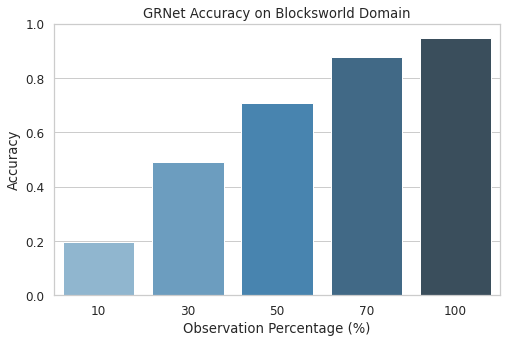

In [64]:
# Set the visual style
sns.set_theme(style="whitegrid", font_scale=1.1)

# Show the accuracy with a seaborn bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=original_accuracy_df, x='observation_percentage', y='accuracy', palette='Blues_d')
plt.ylim(0, 1)
plt.title(f'GRNet Accuracy on {DOMAIN_NAME.capitalize()} Domain')
plt.xlabel('Observation Percentage (%)')
plt.ylabel('Accuracy')
plt.show()

### 3.2 Evaluation | Noisy dataset

Noisy dataset statistics and graphs.

In [65]:
# Load full results dataframe
noisy_full_df = pd.read_csv(join(NOISY_RESULTS_DIR, 'full.csv'))

In [66]:
# Extract final results for observation percentage and noise level
noisy_accuracy_df = pd.DataFrame(columns=['noise_percentage', 'observation_percentage', 'accuracy'])
for noise_level in noisy_full_df['noise_percentage'].unique():
    noise_results = noisy_full_df[noisy_full_df['noise_percentage'] == noise_level]
    for perc in noise_results['observation_percentage'].unique():
        obs_results = noise_results[noise_results['observation_percentage'] == perc]
        accuracy = accuracy_score(obs_results['correct_goal_idx'], obs_results['predicted_goal_idx'])

        # Compute accuracy also exclusively on noisy instances (num_modified_actions > 0) and not noisy ones
        noisy_accuracy = accuracy_score(
            obs_results[obs_results['num_modified_actions'] > 0]['correct_goal_idx'],
            obs_results[obs_results['num_modified_actions'] > 0]['predicted_goal_idx']
        )
        non_noisy_accuracy = accuracy_score(
            obs_results[obs_results['num_modified_actions'] == 0]['correct_goal_idx'],
            obs_results[obs_results['num_modified_actions'] == 0]['predicted_goal_idx']
        )

        noisy_accuracy_df = pd.concat(
            [noisy_accuracy_df, 
             pd.DataFrame({
                 'noise_percentage': [noise_level], 
                 'observation_percentage': [perc], 
                 'accuracy': [accuracy],
                 'noisy_accuracy': [noisy_accuracy],
                 'non_noisy_accuracy': [non_noisy_accuracy]
             })], 
            ignore_index=True
        )

noisy_accuracy_df

,noise_percentage,observation_percentage,accuracy,noisy_accuracy,non_noisy_accuracy
0,5,10,0.186992,0.071429,0.193966
1,5,30,0.471545,0.393443,0.497297
2,5,50,0.646341,0.552083,0.706667
3,5,70,0.804878,0.696429,0.895522
4,5,100,0.934783,0.895833,0.977273
5,10,10,0.182927,0.115385,0.190909
6,10,30,0.443089,0.313131,0.530612
7,10,50,0.589431,0.534722,0.666667
8,10,70,0.804878,0.751479,0.922078
9,10,100,0.847826,0.813333,1.000000


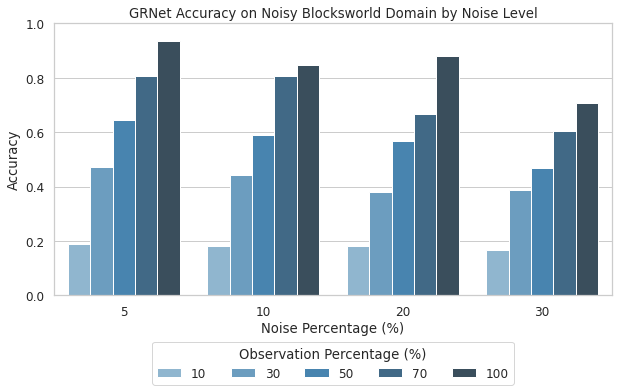

In [67]:
# Set the visual style
sns.set_theme(style="whitegrid", font_scale=1.1)

fig = plt.figure(figsize=(10, 5))
sns.barplot(data=noisy_accuracy_df, x='noise_percentage', y='accuracy', hue='observation_percentage', palette='Blues_d')
plt.ylim(0, 1)
plt.title(f'GRNet Accuracy on Noisy {DOMAIN_NAME.capitalize()} Domain by Noise Level')
plt.xlabel('Noise Percentage (%)')
plt.ylabel('Accuracy')
plt.legend(title='Observation Percentage (%)', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)
plt.show()

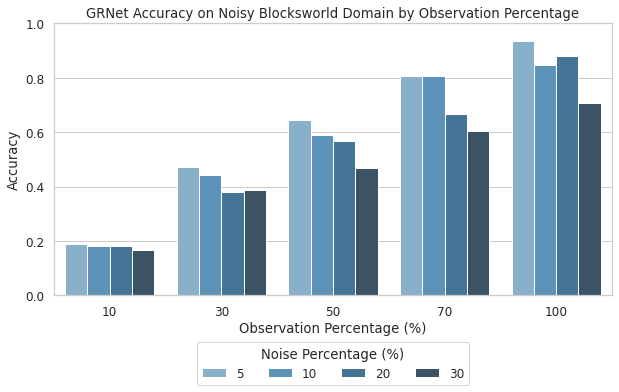

In [68]:
# Set the visual style
sns.set_theme(style="whitegrid", font_scale=1.1)

fig = plt.figure(figsize=(10, 5))
sns.barplot(data=noisy_accuracy_df, x='observation_percentage', y='accuracy', hue='noise_percentage', palette='Blues_d')
plt.ylim(0, 1)
plt.title(f'GRNet Accuracy on Noisy {DOMAIN_NAME.capitalize()} Domain by Observation Percentage')
plt.xlabel('Observation Percentage (%)')
plt.ylabel('Accuracy')
plt.legend(title='Noise Percentage (%)', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)
plt.show()

/tmp/ipykernel_683131/3283639078.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = subset_df.melt(
/tmp/ipykernel_683131/3283639078.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = subset_df.melt(
/tmp/ipykernel_683131/3283639078.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = subset_df.melt(
/tmp/ipykernel_683131/3283639078.py:14: FutureWarning: This dataframe has a column name that matches th

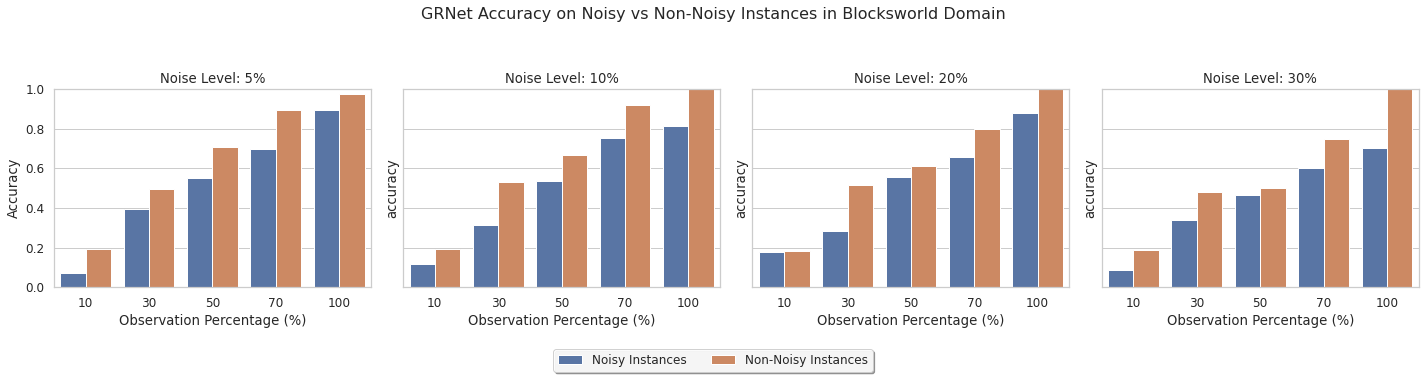

In [69]:
# Set the visual style
sns.set_theme(style="whitegrid", font_scale=1.1)

noise_percs = [5, 10, 20, 30]
obs_percs = [10, 30, 50, 70, 100]

fig, axes = plt.subplots(1, len(noise_percs), figsize=(20, 5), sharey=True)

for ax, noise in zip(axes, noise_percs):
    subset_df = noisy_accuracy_df[
        noisy_accuracy_df['noise_percentage'] == noise
    ]

    melted = subset_df.melt(
        id_vars=['observation_percentage'],
        value_vars=['noisy_accuracy', 'non_noisy_accuracy'],
        var_name='instance_type',
        value_name='accuracy'
    )

    # Make legend labels human-readable
    melted['instance_type'] = melted['instance_type'].map({
        'noisy_accuracy': 'Noisy Instances',
        'non_noisy_accuracy': 'Non-Noisy Instances'
    })

    sns.barplot(
        data=melted,
        x='observation_percentage',
        y='accuracy',
        hue='instance_type',
        ax=ax
    )

    ax.set_title(f'Noise Level: {noise}%')
    ax.set_xlabel('Observation Percentage (%)')
    ax.set_ylim(0, 1)

axes[0].set_ylabel('Accuracy')

# Single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    frameon=True,
    framealpha=0.9,
    fancybox=True,
    shadow=True,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=2
)

for ax in axes:
    ax.legend_.remove()

plt.suptitle(
    f'GRNet Accuracy on Noisy vs Non-Noisy Instances in {DOMAIN_NAME.capitalize()} Domain',
    fontsize=16
)

plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.show()

/tmp/ipykernel_683131/2606433694.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = subset_df.melt(
/tmp/ipykernel_683131/2606433694.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = subset_df.melt(
/tmp/ipykernel_683131/2606433694.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  melted = subset_df.melt(
/tmp/ipykernel_683131/2606433694.py:14: FutureWarning: This dataframe has a column name that matches th

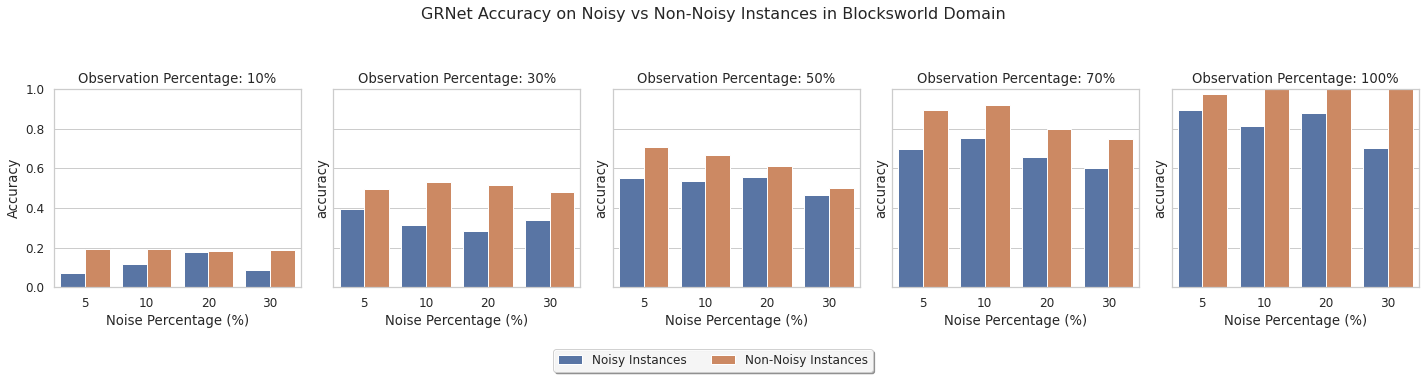

In [70]:
# Set the visual style
sns.set_theme(style="whitegrid", font_scale=1.1)

noise_percs = [5, 10, 20, 30]
obs_percs = [10, 30, 50, 70, 100]

fig, axes = plt.subplots(1, len(obs_percs), figsize=(20, 5), sharey=True)

for ax, obs in zip(axes, obs_percs):
    subset_df = noisy_accuracy_df[
        noisy_accuracy_df['observation_percentage'] == obs
    ]

    melted = subset_df.melt(
        id_vars=['noise_percentage'],
        value_vars=['noisy_accuracy', 'non_noisy_accuracy'],
        var_name='instance_type',
        value_name='accuracy'
    )

    # Make legend labels human-readable
    melted['instance_type'] = melted['instance_type'].map({
        'noisy_accuracy': 'Noisy Instances',
        'non_noisy_accuracy': 'Non-Noisy Instances'
    })

    sns.barplot(
        data=melted,
        x='noise_percentage',
        y='accuracy',
        hue='instance_type',
        ax=ax
    )

    ax.set_title(f'Observation Percentage: {obs}%')
    ax.set_xlabel('Noise Percentage (%)')
    ax.set_ylim(0, 1)

axes[0].set_ylabel('Accuracy')

# Single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    frameon=True,
    framealpha=0.9,
    fancybox=True,
    shadow=True,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=2
)

for ax in axes:
    ax.legend_.remove()

plt.suptitle(
    f'GRNet Accuracy on Noisy vs Non-Noisy Instances in {DOMAIN_NAME.capitalize()} Domain',
    fontsize=16
)

plt.tight_layout(rect=[0, 0.05, 1, 0.92])
plt.show()